In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint
np.set_printoptions(precision=4, linewidth=120, floatmode='maxprec_equal')

In [2]:
import pygsti
import pygsti.extras.interpygate as interp
from pygsti.tools.basistools import change_basis
from pygsti.modelpacks import smq1Q_XY

In [3]:
from pathlib import Path
working_dir = Path.cwd()

## Build model gate

In [4]:
sigI = np.array([[1.,0],[0, 1]], dtype='complex')
sigX = np.array([[0, 1],[1, 0]], dtype='complex')
sigY = np.array([[0,-1],[1, 0]], dtype='complex') * 1.j
sigZ = np.array([[1, 0],[0,-1]], dtype='complex')
sigM = (sigX - 1.j*sigY)/2.
sigP = (sigX + 1.j*sigY)/2.

In [5]:
class SingleQubitTargetOp(pygsti.modelmembers.operations.OpFactory):

    def __init__(self):
        self.process = self.create_target_gate
        pygsti.modelmembers.operations.OpFactory.__init__(self, 4, evotype="densitymx")
        self.dim = 4

    def create_target_gate(self, v):
        
        phi, theta = v
        target_unitary = (np.cos(theta/2) * sigI + 
                          1.j * np.sin(theta/2) * (np.cos(phi) * sigX + np.sin(phi) * sigY))
        superop = change_basis(np.kron(target_unitary.conj(), target_unitary), 'col', 'pp')

        return superop
    
    def create_object(self, args=None, sslbls=None):
        assert(sslbls is None)
        mx = self.process([*args])
        return pygsti.modelmembers.operations.StaticArbitraryOp(mx)

In [6]:
class SingleQubitGate(interp.PhysicalProcess):
    def __init__(self, 
                 verbose=False,
                 cont_param_gate = False,
                 num_params = None,
#                  process_shape = (4, 4),
                 item_shape = (4,4),
                 aux_shape = None,
                 num_params_evaluated_as_group = 0,
                 ):

        self.verbose = verbose

        self.cont_param_gate = cont_param_gate

        self.num_params = num_params
        self.item_shape = item_shape

        self.aux_shape = aux_shape
        self.num_params_evaluated_as_group = num_params_evaluated_as_group

   
    def create_process_matrix(self, v, comm=None, return_generator=False):                                                                                                                                                                                             

        processes = []
        phi, theta, t = v
        theta = theta * t
        target_unitary = (np.cos(theta/2) * sigI + 
                          1.j * np.sin(theta/2) * (np.cos(phi) * sigX + np.sin(phi) * sigY))
        superop = change_basis(np.kron(target_unitary.conj(), target_unitary), 'col', 'pp')
        processes += [superop]
        return np.array(processes) if (processes is not None) else None

    def create_aux_info(self, v, comm=None):
        return []  # matches aux_shape=() above
    
    def create_process_matrices(self, v, grouped_v, comm=None):
        assert(len(grouped_v) == 1)  # we expect a single "grouped" parameter

        processes = []
        times = grouped_v[0]
        phi_in, theta_in = v
        for t in times:
            phi = phi_in
            theta = theta_in * t
            target_unitary = (np.cos(theta/2) * sigI + 
                              1.j * np.sin(theta/2) * (np.cos(phi) * sigX + np.sin(phi) * sigY))
            superop = change_basis(np.kron(target_unitary.conj(), target_unitary), 'col', 'pp')
            processes += [superop]
        return np.array(processes) if (processes is not None) else None

    def create_aux_infos(self, v, grouped_v, comm=None):
        import numpy as np
        times = grouped_v[0]
        return [ [] for t in times] # list elements must match aux_shape=() above

In [7]:
param_ranges = [(0.9,1.1,3)]

arg_ranges = [2*np.pi*(1+np.cos(np.linspace(np.pi,0, 7)))/2,
              (0, np.pi, 3)] 
arg_indices = [0,1]


target_op = SingleQubitTargetOp()
gate_process = SingleQubitGate(num_params = 3,num_params_evaluated_as_group = 1)

In [8]:
opfactory_linear = interp.InterpolatedOpFactory.create_by_interpolating_physical_process(
    target_op, gate_process, argument_ranges=arg_ranges, parameter_ranges=param_ranges, 
    argument_indices=arg_indices, interpolator_and_args='linear')

opfactory_spline = interp.InterpolatedOpFactory.create_by_interpolating_physical_process(
    target_op, gate_process, argument_ranges=arg_ranges, parameter_ranges=param_ranges, 
    argument_indices=arg_indices, interpolator_and_args='spline')


### Check that the interpolator is working

In [9]:
if False:
    indices = (2,3)
    nparams = 30

    x = np.linspace(0,2*np.pi, nparams)
    y = np.linspace(0, np.pi, nparams)
    for p in np.linspace(.9,1.1,5):

        def interp_linear(x, y):    
            op = opfactory_linear.create_op([x, y])
            return op.base_interpolator([x,y,p])[indices]

        def interp_spline(x, y):    
            op = opfactory_spline.create_op([x, y])
            return op.base_interpolator([x,y,p])[indices]

        def truth(x, y):
            tmp_gate = gate_process.create_process_matrix([x,y,p])[0]
            tar_gate = target_op.create_target_gate([x,y])
            return pygsti.error_generator(tmp_gate, tar_gate, 'pp', 'logGTi')[indices]


        X, Y = np.meshgrid(x, y, indexing='ij')
        Z_linear = np.zeros([nparams, nparams])
        Z_spline = np.zeros([nparams, nparams])
        Z_truth  = np.zeros([nparams, nparams])
        for idx, xx in enumerate(x):
            for idy, yy in enumerate(y):
                Z_linear[idx,idy] = interp_linear(xx,yy)
                Z_spline[idx,idy] = interp_spline(xx,yy)
                Z_truth[idx,idy]  = truth(xx,yy)

        fig = plt.figure(figsize=(10,10))
        ax = plt.axes(projection='3d')

        ax.plot_surface(X, Y, Z_linear-Z_truth, rstride=1, cstride=1,
                        edgecolor='none', alpha=.8)
        ax.plot_surface(X, Y, Z_spline-Z_truth, rstride=1, cstride=1,
                        cmap='viridis', edgecolor='none', alpha=.8)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
    #     ax.set_zlim(-1,1)
        plt.show()

# Build a model from this gate

In [10]:
x_gate = opfactory_spline.create_op([0,np.pi/4])
y_gate = opfactory_spline.create_op([np.pi/2,np.pi/4])

In [11]:
x_gate.from_vector([1.03])
y_gate.from_vector([1.0])
print(np.round_(x_gate,4))
print()
print(np.round_(y_gate,4))

[[ 1.0000  0.0000 -0.0000  0.0000]
 [ 0.0000  1.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.6903  0.7236]
 [ 0.0000  0.0000 -0.7236  0.6903]]

[[ 1.0000  0.0000 -0.0000  0.0000]
 [ 0.0000  0.7071  0.0000 -0.7071]
 [-0.0000 -0.0000  1.0000 -0.0000]
 [ 0.0000  0.7071 -0.0000  0.7071]]


## Make a fake dataset

In [12]:
#Model only has Gx and Gy gates.  Let's rename them.

model = pygsti.models.ExplicitOpModel([0],'pp')

model['rho0'] = [ 1/np.sqrt(2), 0, 0, 1/np.sqrt(2) ] # density matrix [[1, 0], [0, 0]] in Pauli basis
model['Mdefault'] = pygsti.modelmembers.povms.UnconstrainedPOVM(
    {'0': [ 1/np.sqrt(2), 0, 0, 1/np.sqrt(2) ],   # projector onto [[1, 0], [0, 0]] in Pauli basis
     '1': [ 1/np.sqrt(2), 0, 0, -1/np.sqrt(2) ] }, evotype="default") # projector onto [[0, 0], [0, 1]] in Pauli basis
model['Gxpi2',0] = x_gate
model['Gypi2',0] = y_gate

In [13]:
model.num_params

14

In [14]:
# Define the error model used to generate data
datagen_model = model.copy()
datagen_params = datagen_model.to_vector()
datagen_params[-2:] = [1.03,1.00]
datagen_model.from_vector(datagen_params)
datagen_model.probabilities( (('Gxpi2',0),('Gypi2',0),))

OutcomeLabelDict([(('0',), 0.7440406663460976), (('1',), 0.2559593336539022)])

In [15]:
model._print_gpindices()

PRINTING MODEL GPINDICES!!!
>>> rho0 [FullState]: 4 params, indices=slice(0, 4, None)
>>> Mdefault [UnconstrainedPOVM]: 8 params, indices=slice(4, 12, None)
>>> Gxpi2:0 [InterpolatedDenseOp]: 1 params, indices=slice(12, 13, None)
>>> Gypi2:0 [InterpolatedDenseOp]: 1 params, indices=slice(13, 14, None)


In [16]:
# # Link the over-rotation errors on Gx and Gy
# model['rho0'].set_gpindices(slice(0,4),model)
# model['Mdefault'].set_gpindices(slice(4,12),model)
# model['Gxpi2',0].set_gpindices(slice(12,13),model)
# model['Gypi2',0].set_gpindices(slice(12,13),model)
# model._rebuild_paramvec()
# model._print_gpindices()
print(model.num_params)

# # Define the error model used to generate data
# datagen_model = model.copy()
# datagen_params = datagen_model.to_vector()
# datagen_params[-1:] = [1.02]
# datagen_model.from_vector(datagen_params)
# datagen_model.probabilities( (('Gxpi2',0),('Gypi2',0),))

14


In [17]:
# Define the perfect target model
target_model = model.copy()
target_params = target_model.to_vector()
target_params[-2:] = [1,1]
# target_model.from_vector(target_params)
target_model.probabilities( (('Gxpi2',0),('Gypi2',0),))

OutcomeLabelDict([(('0',), 0.7440406663460976), (('1',), 0.2559593336539022)])

### Germ and fiducial selection

In [18]:
final_germs = pygsti.algorithms.germselection.find_germs(
                target_model, randomize=False, force=None, algorithm='greedy', 
                verbosity=4, num_nongauge_params=2)

Using greedy algorithm.
Complete initial germ set succeeds on all input models.
Now searching for best germ set.
Starting germ set optimization. Lower score is better.
  Outer iteration: 1 of 2 amplified, 0 germs
    Inner iter over candidate germs [##################################################] 100.0% Gxpi2:0Gypi2:0Gypi2:0Gypi2:0Gypi2:0Gypi2:0@(0)
    Added Gypi2:0@(0) to final germs (Score: major=-1.0 minor=0.8105694654717684, N: 1)
  Outer iteration: 1 of 2 amplified, 1 germs
    Inner iter over candidate germs [##################################################] 100.0% Gxpi2:0Gypi2:0Gypi2:0Gypi2:0Gypi2:0Gypi2:0@(0)
    Added Gxpi2:0@(0) to final germs (Score: major=-2.0 minor=1.621138935590229, N: 2)
  Outer iteration: 2 of 2 amplified, 2 germs
Constructed germ set:
['Gypi2:0@(0)', 'Gxpi2:0@(0)']
Score: Score: major=0.0 minor=inf, N: 0


In [19]:
fiducial_pairs = pygsti.algorithms.fiducialpairreduction.find_sufficient_fiducial_pairs_per_germ(
                                model, 
                                smq1Q_XY.prep_fiducials([0]),
                                smq1Q_XY.meas_fiducials([0]), 
                                final_germs)

In [26]:
# # Reduce the number of fiducial pairs by hand, if you want

# fiducial_pairs2 = fiducial_pairs.copy()
# for key in fiducial_pairs2.keys():
#     fiducial_pairs2[key] = fiducial_pairs2[key][0:2]
# fiducial_pairs = fiducial_pairs2

# print(fiducial_pairs)

{Circuit(Gypi2:0@(0)): [(0, 0), (0, 1)], Circuit(Gxpi2:0@(0)): [(0, 0), (0, 1)]}


In [78]:
working_dir = Path.cwd() / 'example_files'

# get experiment design from smq1Q_XY
# exp_design = smq1Q_XY.get_gst_experiment_design(max_max_length=32,qubit_labels=('Q0',))  

# Use fiducial pair reductions
exp_design = pygsti.protocols.StandardGSTDesign(model, 
                                                smq1Q_XY.prep_fiducials([0]), 
                                                smq1Q_XY.meas_fiducials([0]), 
                                                final_germs, 
                                                max_lengths=[1,2,4,8,16,32,64,128,256], 
                                                fiducial_pairs=fiducial_pairs,
                                                include_lgst=False)

# write an empty data object (creates a template to fill in)
pygsti.io.write_empty_protocol_data(exp_design, working_dir, clobber_ok=True)

# fill in the template with simulated data (you would run the experiment and use actual data)
pygsti.io.fill_in_empty_dataset_with_fake_data(
    datagen_model,
    working_dir / 'data/dataset.txt', num_samples=1000, seed=1234)

# load the data object back in, now with the experimental data
data = pygsti.io.load_data_from_dir(working_dir)

In [76]:
len(data.dataset)

35

## Fisher information matrix

What is the expected covariance in the estimated parameters given the specified experiment? Assuming the GST estimator is unbiased,

$$ \mathrm{cov}\left(\left\langle \vec \theta \right\rangle\right) \le I(\theta)^{-1}$$

Where $I(\vec\theta)$ is the Fisher information matrix, with entries:

$$ I_{m,n} = - \left\langle \frac{\partial^2}{\partial \theta_m \partial \theta_n} \mathrm{log} f(x;\vec\theta) \right\rangle $$

Here $f(x;\vec\theta)$ is the likelihood function. For a single quantum circuit, it is equal to:

$$ f(x;\vec\theta) = \prod_i p_i(\theta)^{x_i} $$

Where $p_i(theta)$ is the probability of measuring the $i$th possible outcome, and $x_i$ is the number of times that outcome was observed. The logarithmic derivatives can be evaluated as:

$$
\begin{align}
I_{m,n} &= - \sum_i \left\langle x_i \frac{\partial^2}{\partial \theta_m \partial \theta_n}  \log p_i(\vec\theta)\right\rangle  \\
        &= - \sum_i \left\langle x_i \frac{\partial}{\partial \theta_m }  \frac{\partial \theta_n p_i(\vec\theta)}{p_i(\vec\theta)}\right\rangle  \\
        &= - \sum_i \left\langle x_i \left(\frac{\partial\theta_m \partial \theta_n p_i(\vec\theta)}{p_i(\vec\theta)} - 
        \frac{(\partial\theta_m p_i(\vec\theta) )(\partial\theta_n p_i(\vec\theta))}{p_i(\vec\theta)^2} \right)
        \right\rangle  \\
I &= N \sum_i \left( 
        \frac{(\nabla p_i(\vec\theta) )(\nabla p_i(\vec\theta))^\mathsf{T}}{p_i(\vec\theta)} -
        \nabla\nabla p_i(\vec\theta) \right) \vert_{\theta = \theta_0}\\
&= N \sum_i \left( 
        \frac{J_i J_i^\mathsf{T}}{p_i} - H_i \right) \vert_{\theta = \theta_0}        
\end{align}
$$



In [88]:
def fisher_information_matrix(model, circuit_list):
    n_params = model.num_params
    outcomes = model.sim.probs(()).keys()
    fisher_information = np.zeros([n_params, n_params])
    for circuit in circuit_list:
        p = model.sim.probs (circuit)
        j = model.sim.dprobs(circuit)
        h = model.sim.hprobs(circuit)
        for outcome in outcomes:
            fisher_information += np.outer(j[outcome], j[outcome])/p[outcome] - h[outcome]        
    return fisher_information

In [93]:
fim = fisher_information_matrix(model, exp_design.all_circuits_needing_data[0:2])

In [99]:
np.log(np.linalg.inv(fisher_information_matrix(model, exp_design.all_circuits_needing_data[0:6])))

<ipython-input-99-7b56a9d3cdc6>:1: RuntimeWarning: invalid value encountered in log
  np.log(np.linalg.inv(fisher_information_matrix(model, exp_design.all_circuits_needing_data[0:6])))


array([[ -2.4849,      nan, -35.1551,  -2.4849,      nan,      nan, -34.3222, -35.3782, -34.5673, -34.6851,      nan,
        -36.0714,      nan,      nan],
       [     nan,   1.3541,      nan,   0.9474,   1.3862,   0.7837,      nan,      nan,      nan,      nan,   0.5966,
          1.8351,   1.1788,   1.7805],
       [-35.2635,      nan,  -0.1295,      nan,      nan,      nan,  -0.9581,   1.0328,   0.5676,   0.3140,      nan,
             nan,      nan,      nan],
       [ -2.4849,   0.9474,      nan,   0.5923,   1.0365,   0.5696,      nan,      nan,      nan,      nan,   0.0500,
          1.4359,   0.8999,   1.3422],
       [     nan,   1.3862,      nan,   1.0365,   1.9922,   1.6898,      nan,      nan,      nan,      nan,   1.4629,
          2.0662,   1.3962,   1.7764],
       [     nan,   0.7837,      nan,   0.5696,   1.6898,   1.5024,      nan,      nan,      nan,      nan,   1.1590,
          1.6392,   1.1709,   1.1678],
       [-34.8032,      nan,  -0.9581,      nan,      nan, 

In [94]:
np.linalg.eig(np.linalg.inv(fim))

(array([ 2.5000e-01+0.0000e+00j, -3.9005e+15+1.1457e+15j, -3.9005e+15-1.1457e+15j,  5.3603e+14+0.0000e+00j,
         1.4888e+14+0.0000e+00j,  2.8210e+00+0.0000e+00j,  1.1441e+00+0.0000e+00j, -4.9274e-01+0.0000e+00j,
        -3.7677e-01+4.9547e-02j, -3.7677e-01-4.9547e-02j,  4.3818e-01+1.0126e-01j,  4.3818e-01-1.0126e-01j,
         2.4698e-01+3.9999e-02j,  2.4698e-01-3.9999e-02j]),
 array([[ 1.0000e+00+0.0000e+00j,  2.6254e-17-2.8793e-17j,  2.6254e-17+2.8793e-17j, -1.5293e-16+0.0000e+00j,
          7.8796e-18+0.0000e+00j, -6.6313e-02+0.0000e+00j, -2.5171e-01+0.0000e+00j,  1.6226e-01+0.0000e+00j,
          1.6653e-02-1.2934e-01j,  1.6653e-02+1.2934e-01j,  4.6007e-01+0.0000e+00j,  4.6007e-01-0.0000e+00j,
          9.1612e-01+0.0000e+00j,  9.1612e-01-0.0000e+00j],
        [ 0.0000e+00+0.0000e+00j,  5.4595e-03-1.4286e-03j,  5.4595e-03+1.4286e-03j,  6.0662e-02+0.0000e+00j,
         -4.8244e-01+0.0000e+00j, -2.5079e-02+0.0000e+00j, -1.3608e-01+0.0000e+00j,  1.1794e-01+0.0000e+00j,
          3

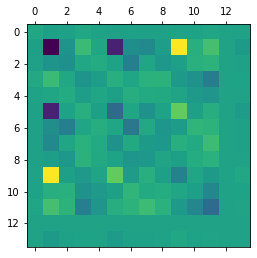

In [90]:
plt.matshow(np.linalg.inv(fim))

# Run GST on the dataset

In [30]:
proto = pygsti.protocols.GateSetTomography(target_model)
results = proto.run(data)

--- Iterative GST: Iter 1 of 9  4 circuits ---: 
  MatrixLayout: 1 processors divided into 1 x 1 (= 1) grid along circuit and parameter directions.
     1 atoms, parameter block size limits (None,)
  *** Distributing 1 atoms to 1 atom-processing groups (1 cores) ***
      More atom-processors than hosts: each host gets ~1 atom-processors
      Atom-processors already occupy a single node, dividing atom-processor into 1 param-processors.
  *** Divided 1-host atom-processor (~1 procs) into 1 param-processing groups ***
  --- chi2 GST ---
  Sum of Chi^2 = 0.0112986 (4 data params - 14 (approx) model params = expected mean of -10; p-value = nan)
  Completed in 0.1s
  Iteration 1 took 0.1s
  
--- Iterative GST: Iter 2 of 9  7 circuits ---: 
  MatrixLayout: 1 processors divided into 1 x 1 (= 1) grid along circuit and parameter directions.
     1 atoms, parameter block size limits (None,)
  *** Distributing 1 atoms to 1 atom-processing groups (1 cores) ***
      More atom-processors than host

In [31]:
# What is the estimated value of the error parameter?

final_model = results.estimates['GateSetTomography'].models['final iteration estimate']
print('Actual: ', datagen_model.to_vector()[-2:])
print('Estimated: ', final_model.to_vector()[-2:])

Actual:  [1.03 1.00]
Estimated:  [1.0304 1.0000]


In [32]:
pprint(np.sqrt(2)*final_model.to_vector()[0:4])
pprint(np.sqrt(2)*final_model.to_vector()[4:8])
pprint(np.sqrt(2)*final_model.to_vector()[8:12])

array([ 1.0001, -0.0730, -0.0239,  0.9976])
array([ 1.0064, -0.0219, -0.0209,  1.0079])
array([ 0.9969,  0.0461,  0.0113, -0.9958])
